# ONE WARE - Predictive Maintenance Task 

### The Task

For an overview of the task, please refer to [the Readme](https://github.com/Friedrich-Mueller/ai_solutions/tree/master/predictive_maintenance)

Since the task is rather comprehensive, I chose to document only my though process within this notebook, leaving the tasks instructions out.

### Imports


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F

import kagglehub
import shutil
from pathlib import Path

### Verifty Cuda Functionality

In [2]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version PyTorch was built with: {torch.version.cuda}")
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")
    
    # Check compute capability
    capability = torch.cuda.get_device_capability(0)
    print(f"GPU Compute Capability: {capability[0]}.{capability[1]}")
else:
    print("No GPU detected. PyTorch will run on CPU.")

PyTorch version: 2.5.1
CUDA available: True
CUDA version PyTorch was built with: 12.1
Current GPU: NVIDIA GeForce RTX 3060 Ti
GPU Compute Capability: 8.6


### Download Dataset 

Dataset of choice is the [One Year Industrial Component Degradation](https://www.kaggle.com/datasets/inIT-OWL/one-year-industrial-component-degradation/data).

The "One-Year Industrial Component Degradation" is a high-quality, real-world Predictive Maintenance (PdM) dataset that allows to infer from raw sensor signals a state/health detection. The data covers the state of a cutting blade that is used in some industrial machine. Since the blade can not be inspected visually during operation due to the blade being enclosed in a metal housing and its fast rotation speed, predictive maintance can be applied to monitor its degradation.

The data covers the state of the blade over the span of a whole year. We assume that at the beginning of that year in which the data was farmed, the blade was in some 'best' state, which is either perfect condition or acceptable condition or something inbetween. And for the sake of the task, we assume that in the last 5% of the time (e.g. end of the year) the blade enters a state of some 'maximum' degradation which requires maintenance.


This task could be a classification task, where each sample is binned via equal frequency (or equal depth). But also, it could be a regression task, where each sample is assigned a percentage of degradation based on its position on the timeline. 

Due to the nature of the blade being used in different 'modes', there is an assumption that perhaps some modes are only used rarely. For example, if for whatever reason, one mode was only used once near the end of the year, and equal frequency binning would be applied, it could happen that said rare mode would be binned in the respectively latest bin, which would represent 95-100% degradation and indicate a need for maintenance. Now if that mode was used at an earlier point in a following year, the monitoring would immediately suggest a maintenance. 

Therefore, applying a regression based solution makes alot more sense, with the assumption of a continuous degradation of the blade, regardless of mode.

In [3]:
download_path = Path(
    kagglehub.dataset_download("inIT-OWL/one-year-industrial-component-degradation")
)

source_path = download_path / "oneyeardata"

print(f"Extracting data from: {source_path}")

# Target directory
data_dir = Path("..") / "data"
data_dir.mkdir(parents=True, exist_ok=True)

# Copy files
for item in source_path.iterdir():
    dest = data_dir / item.name
    if item.is_dir():
        shutil.copytree(item, dest, dirs_exist_ok=True)
    else:
        shutil.copy2(item, dest)

print("Dataset successfully copied to:", data_dir.resolve())

Extracting data from: /home/fjunpop/.cache/kagglehub/datasets/inIT-OWL/one-year-industrial-component-degradation/versions/1/oneyeardata
Dataset successfully copied to: /home/fjunpop/ai_solutions/predictive_maintenance/data


### Extract/Engineer the data

In [4]:
# Master Dataset
data_dir = Path("..") / "data"
file_list = sorted(list(data_dir.glob("*.csv")))

all_dfs = []

for file_path in file_list:
    file_df = pd.read_csv(file_path)
    file_df['mode'] = int(file_path.stem[-1])
    all_dfs.append(file_df)

master_df = pd.concat(all_dfs, ignore_index=True)
total_rows = len(master_df)

master_df['health'] = np.linspace(1.0, 0.0, total_rows)

In [5]:
print("Columns before cleaning:\n", master_df.columns.tolist())
print("\nColumns len:\n", len(master_df.columns.tolist()))
master_df.drop(columns="timestamp", inplace=True, errors='ignore')
print("\nColumns after cleaning:\n", master_df.columns.tolist())
print("\nColumns len:\n", len(master_df.columns.tolist()))


print("\nMaster df shape:\n", master_df.shape)

Columns before cleaning:
 ['timestamp', 'pCut::Motor_Torque', 'pCut::CTRL_Position_controller::Lag_error', 'pCut::CTRL_Position_controller::Actual_position', 'pCut::CTRL_Position_controller::Actual_speed', 'pSvolFilm::CTRL_Position_controller::Actual_position', 'pSvolFilm::CTRL_Position_controller::Actual_speed', 'pSvolFilm::CTRL_Position_controller::Lag_error', 'pSpintor::VAX_speed', 'mode', 'health']

Columns len:
 11

Columns after cleaning:
 ['pCut::Motor_Torque', 'pCut::CTRL_Position_controller::Lag_error', 'pCut::CTRL_Position_controller::Actual_position', 'pCut::CTRL_Position_controller::Actual_speed', 'pSvolFilm::CTRL_Position_controller::Actual_position', 'pSvolFilm::CTRL_Position_controller::Actual_speed', 'pSvolFilm::CTRL_Position_controller::Lag_error', 'pSpintor::VAX_speed', 'mode', 'health']

Columns len:
 10

Master df shape:
 (1062912, 10)


### EDA

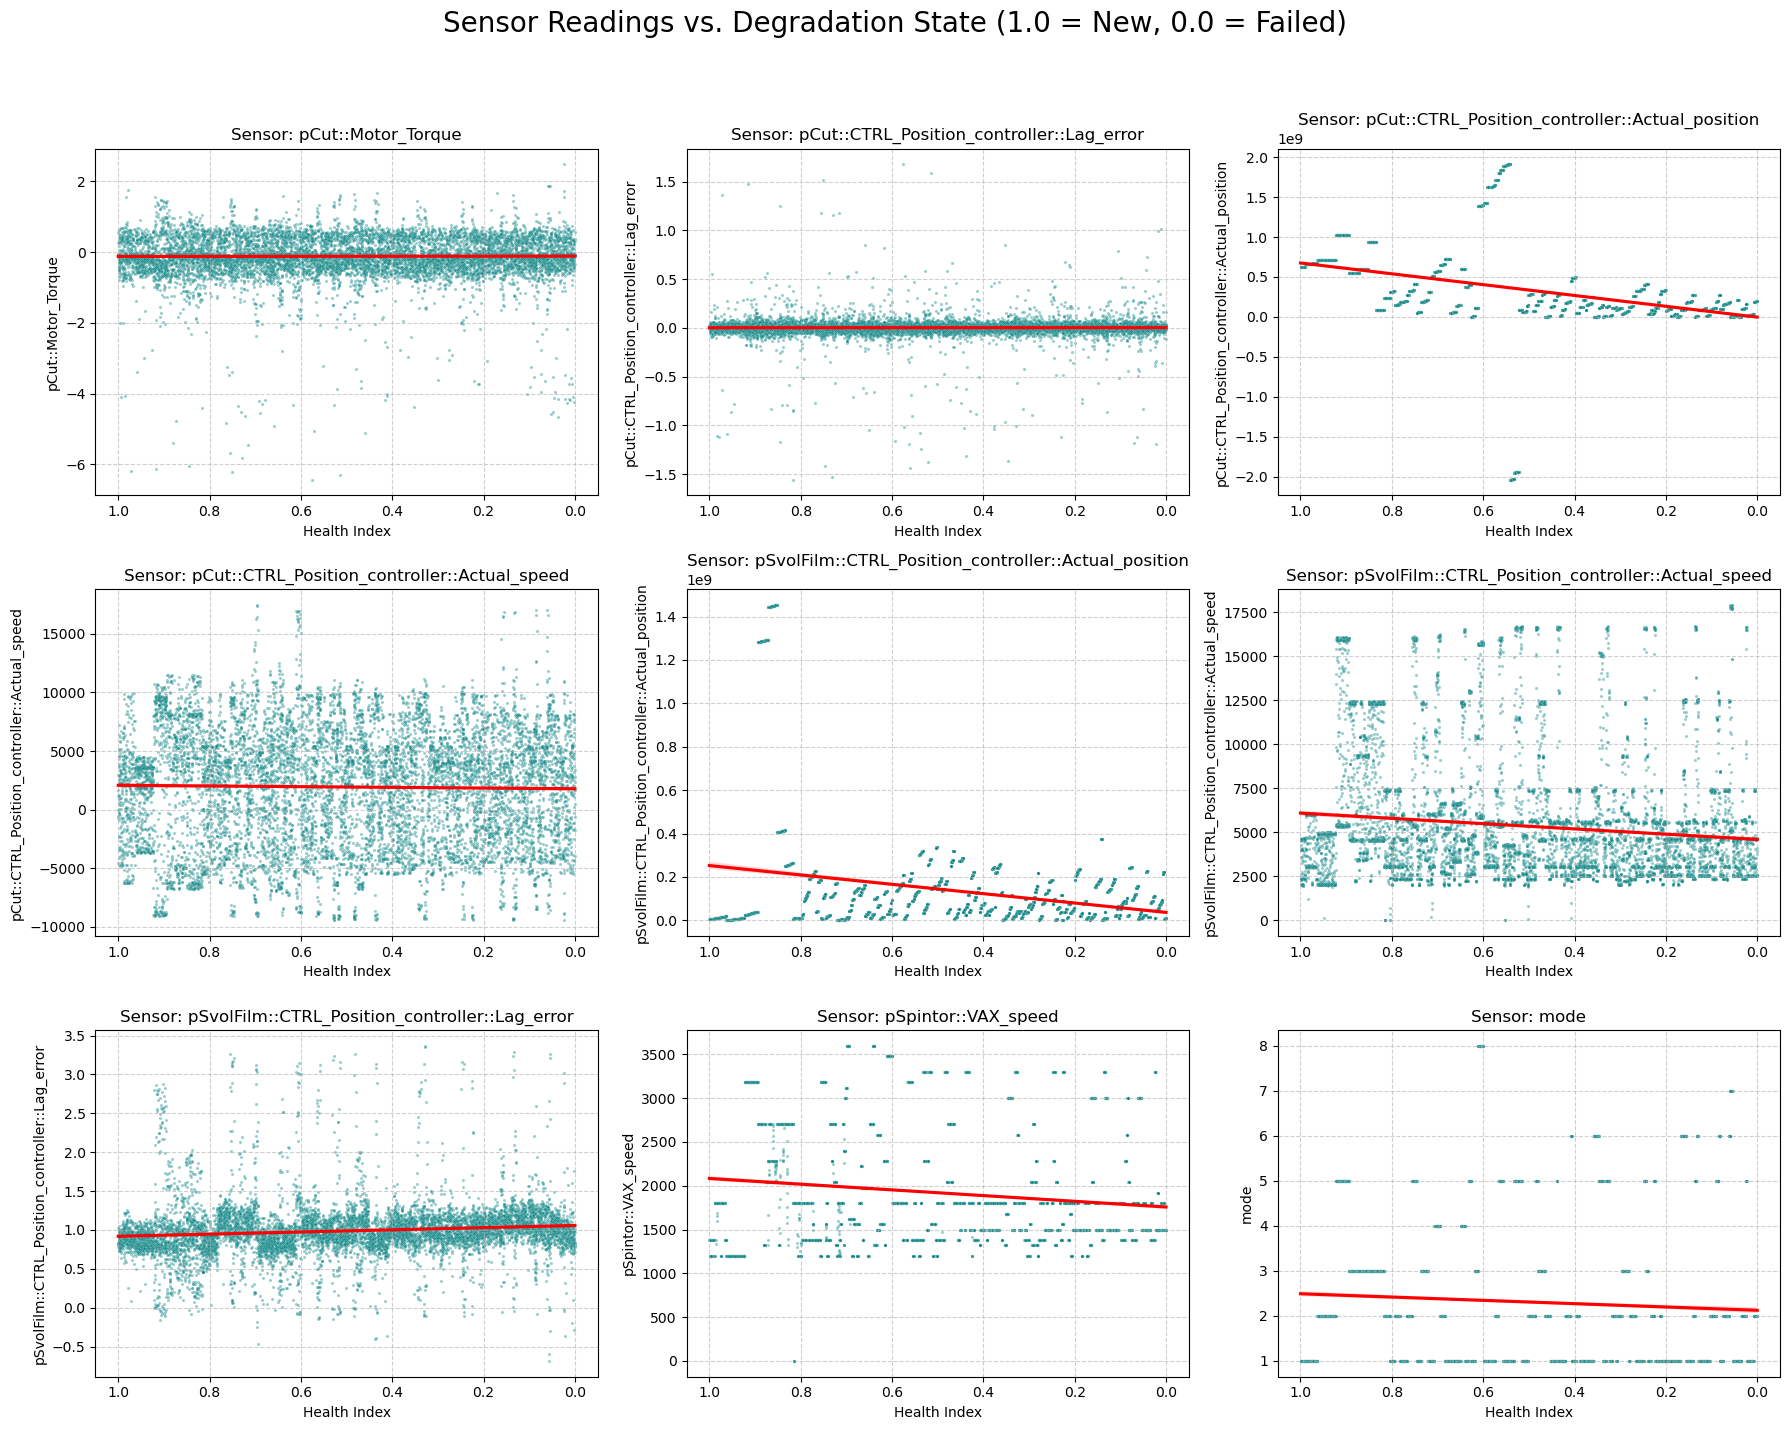

In [6]:
# Sensor Readings vs. Degradation State 

sensor_cols = master_df.columns.tolist()[:-1]

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Sensor Readings vs. Degradation State (1.0 = New, 0.0 = Failed)', fontsize=20)
axes = axes.flatten()
plot_sample = master_df.sample(n=10000, random_state=42)

for i, col in enumerate(sensor_cols):
    # Scatter plot with low alpha (transparency) helps see density
    sns.scatterplot(
        data=plot_sample, 
        x='health', 
        y=col, 
        ax=axes[i], 
        s=5, 
        alpha=0.4, 
        color='teal'
    )
    
    # Add a trend line (regression line) to see the general direction of wear
    sns.regplot(
        data=plot_sample, 
        x='health', 
        y=col, 
        ax=axes[i], 
        scatter=False, 
        color='red', 
        lowess=False
    )
    
    axes[i].set_title(f'Sensor: {col}', fontsize=12)
    axes[i].set_xlabel('Health Index')
    axes[i].invert_xaxis() # Optional: flip so the plot goes from Left (New) to Right (Old)
    axes[i].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

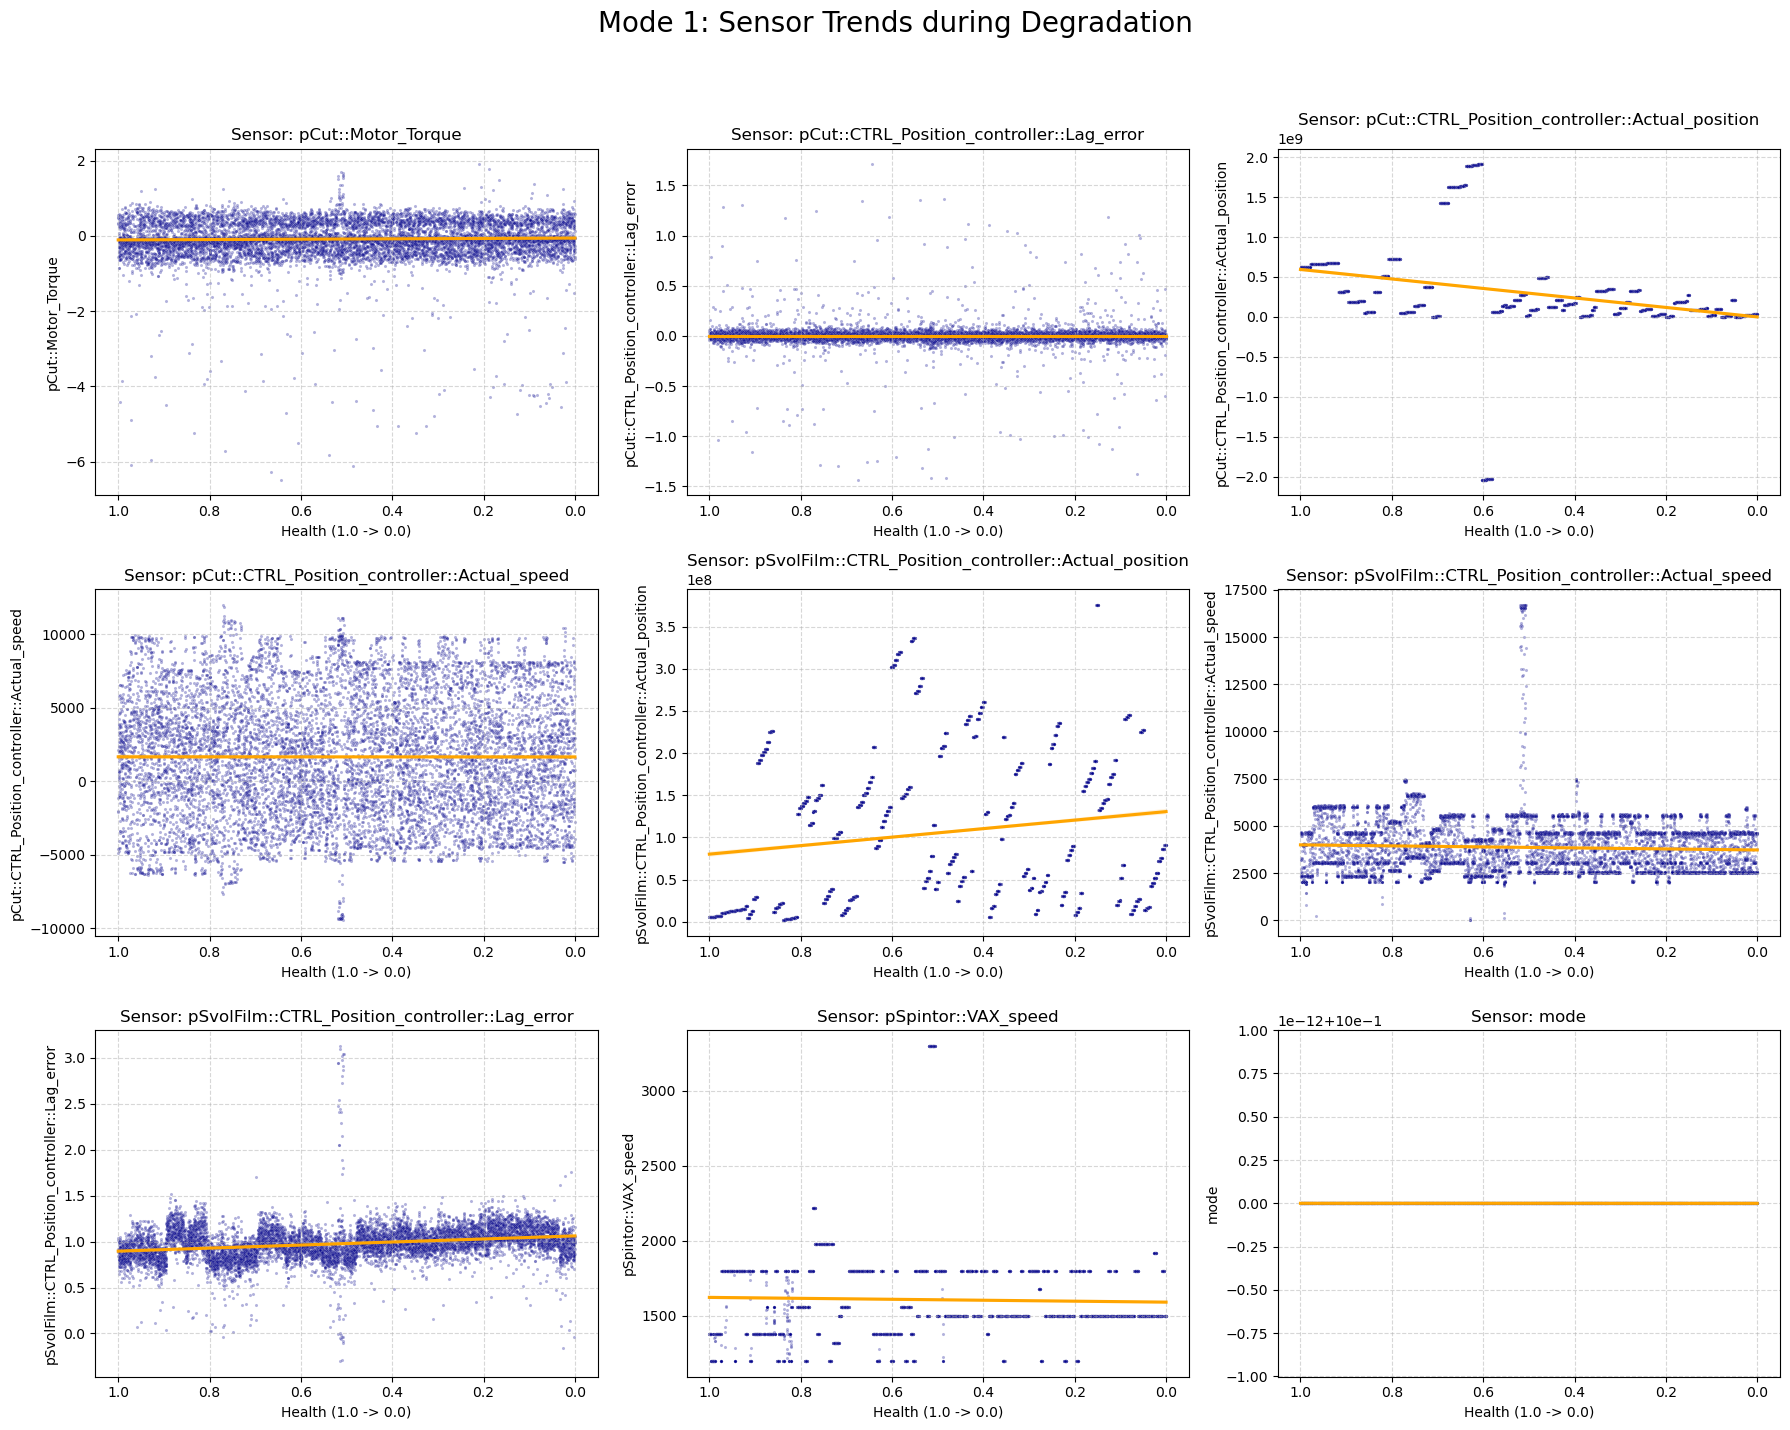

In [7]:
# Sensor Readings vs. Degradation State - mode 1 only

mode1_df = master_df[master_df['mode'] == 1].copy()

total_mode1_rows = len(mode1_df)
mode1_df['health'] = np.linspace(1.0, 0.0, total_mode1_rows)

mode1_df = mode1_df.reset_index(drop=True)

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Mode 1: Sensor Trends during Degradation', fontsize=20)
axes = axes.flatten()
plot_sample = mode1_df.sample(n=min(10000, len(mode1_df)), random_state=42)

for i, col in enumerate(sensor_cols):
    # Scatter plot
    sns.scatterplot(
        data=plot_sample, 
        x='health', 
        y=col, 
        ax=axes[i], 
        s=5, 
        alpha=0.3, 
        color='darkblue'
    )
    
    # Linear trend line (doesn't require statsmodels)
    sns.regplot(
        data=plot_sample, 
        x='health', 
        y=col, 
        ax=axes[i], 
        scatter=False, 
        color='orange', 
        lowess=False
    )
    
    axes[i].set_title(f'Sensor: {col}', fontsize=12)
    axes[i].set_xlabel('Health (1.0 -> 0.0)')
    axes[i].invert_xaxis() # Keep the "timeline" flow
    axes[i].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

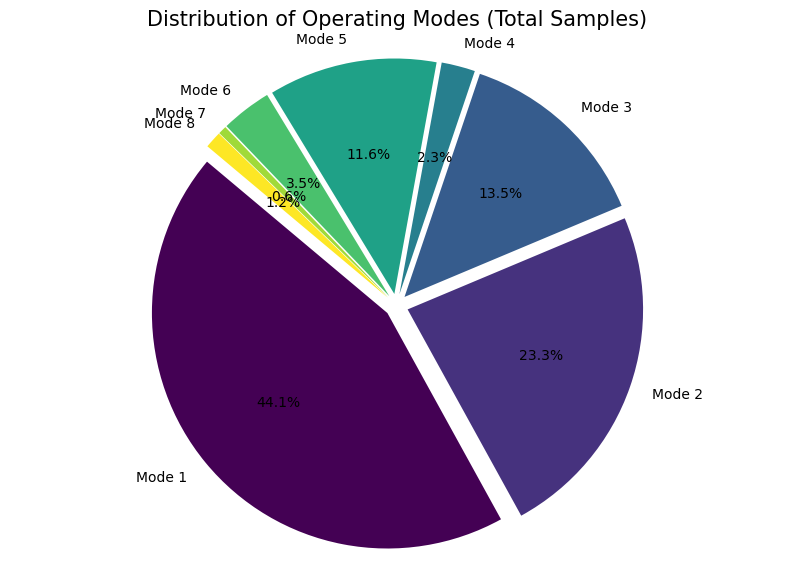

In [8]:
# Pie chart for mode distribution

mode_distribution = master_df['mode'].value_counts().sort_index()

plt.figure(figsize=(10, 7))
plt.pie(
    mode_distribution, 
    labels=[f"Mode {int(m)}" for m in mode_distribution.index], 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=plt.cm.viridis(np.linspace(0, 1, len(mode_distribution))),
    explode=[0.05] * len(mode_distribution)  # Slightly separate slices
)

plt.title('Distribution of Operating Modes (Total Samples)', fontsize=15)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Total files: 519
Total mode switches: 77
On average, the machine stays in a mode for 6.65 files.


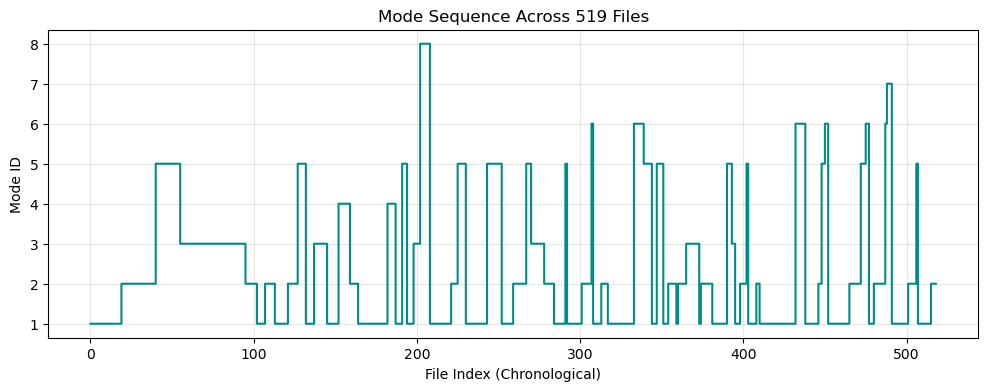

In [9]:
# Amount of mode switches

mode_sequence = [int(f.stem[-1]) for f in file_list]

switches = 0
switch_locations = []

for i in range(1, len(mode_sequence)):
    if mode_sequence[i] != mode_sequence[i-1]:
        switches += 1
        switch_locations.append(i)

print(f"Total files: {len(mode_sequence)}")
print(f"Total mode switches: {switches}")

avg_files_per_mode = len(mode_sequence) / (switches + 1)
print(f"On average, the machine stays in a mode for {avg_files_per_mode:.2f} files.")

file_modes = [int(f.stem[-1]) for f in file_list]

plt.figure(figsize=(12, 4))
plt.step(range(len(file_modes)), file_modes, where='post', color='darkcyan')
plt.title(f"Mode Sequence Across {len(file_list)} Files")
plt.xlabel("File Index (Chronological)")
plt.ylabel("Mode ID")
plt.grid(alpha=0.3)
plt.show()

### EDA Conclusion

There are 8 different modes, some of which differ vastly from each other. Therefore it is feasable to concat an embedding that represents the mode to each sample.

There is still an issue with certain modes potentially occuring too rarely, e.g. mode 8. But there is potential for a model to extrapolate to mitigate this unfortunate circumstance, and additionally there are strategys and thresholds that can be picked when the trained model is used for inference. E.g. an average of degradation based on data from the last 2-4 weeks could mitigate bad performance on rare/irregular modes. Another strategy would be to weight the predictions, based on the prevalence of a given mode, e.g. modes 1, 2, 3 and 5 seem to be reliable sources for degradation inference.


#### Valid-Windows Only Rule

To avoid windows that consists of timesteps that belong to more than one mode, the strategy of choice here is the valid-windows only rule, which restricts windows to include exclusively data samples from a single mode.

This choice is encouraged by the relatively low number of mode switches in comparison to the total amount of records. E.g. with a window size of 64 and switches count of 77 and a sample size of 1062912, less than 0.5% of data is lost ((77*64)/1062912 $\approx$ 0.0046), for the reward of not confusing the model with windows that contain records from different modes.

In this specific dataset, the data is stored in files where each file usually represents a single mode and contains exactly 2048 samples (of a 8 second time span). Hence, the smallest valid window is 2048 samples, which is relevant in the choice of the size of the window that is fed to the CNN/CNNs, as optimally, the chosen sliding window size should not be bigger than the smallest valid-window.



### Normalization

In [10]:
context_cols = ['mode', 'health']
sensor_cols = [c for c in master_df.columns if c not in context_cols]

master_df_norm = master_df.copy()

scaler = StandardScaler()
master_df_norm[sensor_cols] = scaler.fit_transform(master_df[sensor_cols])

print(master_df_norm.shape)


print(f"Mean of non-normalized sensors (approx 0): {master_df[sensor_cols[0]].mean():.4f}")
print(f"Std of non-normalized sensors (approx 1): {master_df[sensor_cols[0]].std():.4f}")

print(f"Mean of normalized sensors (approx 0): {master_df_norm[sensor_cols[0]].mean():.4f}")
print(f"Std of normalized sensors (approx 1): {master_df_norm[sensor_cols[0]].std():.4f}")
# print(master_df_norm.loc[0,:])

(1062912, 10)
Mean of non-normalized sensors (approx 0): -0.1206
Std of non-normalized sensors (approx 1): 0.6079
Mean of normalized sensors (approx 0): 0.0000
Std of normalized sensors (approx 1): 1.0000


### Train-Test-Split

In [11]:
# Each file has 2048 rows. Let's group them.
rows_per_file = 2048
total_files = len(master_df_norm) // rows_per_file

# Create a list of file IDs [0, 1, 2, ..., 518]
file_ids = np.arange(total_files)

# Randomly pick 20% of the FILES, not the rows.
# This ensures that if File #10 is in the test set, ALL 2048 consecutive 
# samples of that run are kept together and away from the training set.
train_ids, test_ids = train_test_split(file_ids, test_size=0.2, random_state=42)

# Helper to grab the rows belonging to those files
def get_rows_by_file_id(df, ids, size):
    return pd.concat([df.iloc[i*size : (i+1)*size] for i in ids])

train_df = get_rows_by_file_id(master_df_norm, train_ids, rows_per_file)
test_df = get_rows_by_file_id(master_df_norm, test_ids, rows_per_file)
# print(train_df)

### Create Windows

In [12]:
def create_sliding_windows(df, window_size=64, step=16):
    # Separate sensor data and mode/target
    sensors = df[sensor_cols].values
    modes = (df['mode'] - 1).values  # Shift to 0-7 for the embedding layer
    targets = df['health'].values
    
    X_sensors, X_modes, y = [], [], []
    
    # Logic: Only create windows if the entire window belongs to the SAME mode
    # We iterate by window_size to avoid crossing file boundaries (each file is 2048)
    for i in range(0, len(df) - window_size + 1, step):
        window_mode = modes[i : i + window_size]
        
        # Verify "Valid-Windows Only Rule": all samples in window have same mode
        if np.all(window_mode == window_mode[0]):
            X_sensors.append(sensors[i : i + window_size])
            X_modes.append(window_mode[0])
            y.append(targets[i + window_size - 1]) # Target is health at end of window

    return np.array(X_sensors), np.array(X_modes), np.array(y)

# Generate windows for training
X_train_s, X_train_m, y_train = create_sliding_windows(train_df, window_size=64, step=16) #e.g. step = 1/4 of window_size equals 75% overlap 

print(f"Sensors shape (Samples, Time, Features): {X_train_s.shape}")
print(f"Modes shape (Samples,): {X_train_m.shape}")

# Generate windows for testing
X_test_s, X_test_m, y_test = create_sliding_windows(test_df, window_size=64, step=16)

print(f"Training windows: {X_train_s.shape[0]}")
print(f"Testing windows: {X_test_s.shape[0]}")

Sensors shape (Samples, Time, Features): (52217, 64, 8)
Modes shape (Samples,): (52217,)
Training windows: 52217
Testing windows: 13069


### Badeline CNN (Sensors and Mode combined)

In [13]:
class BaselineCNN(nn.Module):
    def __init__(self, num_sensors):
        super(BaselineCNN, self).__init__()
        
        # 1D Conv layers: (Input Channels, Output Channels, Kernel Size)
        # Input Channels = Number of sensors
        self.conv1 = nn.Conv1d(in_channels=num_sensors, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # Global Pooling to condense time dimension
        self.pool = nn.AdaptiveAvgPool1d(1)
        
        # Fully connected layers for the regression output
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1) # Single output for health index
        
    def forward(self, x):
        # PyTorch expects (Batch, Channels, TimeSteps)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        
        x = self.pool(x).squeeze(-1) # Flatten the time dimension
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # No activation here because it's regression
        return x

### Dual-Channel-CNN (Sensors and Mode separated)

In [14]:
class DualChannelCNN(nn.Module):
    def __init__(self, num_sensors, num_modes=8, embed_dim=4):
        super(DualChannelCNN, self).__init__()
        
        # Branch 1: Sensor CNN
        self.conv1 = nn.Conv1d(in_channels=num_sensors, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool1d(1)
        
        # Branch 2: Mode Embedding
        # This treats Mode as a lookup table, not a magnitude
        self.mode_embed = nn.Embedding(num_embeddings=num_modes, embedding_dim=embed_dim)
        
        # Fusion Layer
        # Concatenates 64 (CNN output) + 4 (Embedding output)
        self.fc1 = nn.Linear(64 + embed_dim, 32)
        self.fc2 = nn.Linear(32, 1)
        
    def forward(self, x_sensors, x_mode):
        # x_sensors: (Batch, 8, 64)
        # x_mode: (Batch, 1) -> integer indices 0-7
        
        # Process Sensors
        s = F.relu(self.conv1(x_sensors))
        s = F.relu(self.conv2(s))
        s = self.pool(s).squeeze(-1)
        
        # Process Mode
        m = self.mode_embed(x_mode).squeeze(1) # Result: (Batch, 4)
        
        # Concatenate
        combined = torch.cat((s, m), dim=1)
        
        # Decision Head
        x = F.relu(self.fc1(combined))
        return self.fc2(x)

### Preparing the Dataloaders

In [15]:
# --- PREPARE BASELINE DATA (Single Tensor: 8 sensors + 1 mode) ---
# Combine sensor and mode for the baseline input
X_train_baseline = torch.tensor(np.concatenate([X_train_s, X_train_m[:, None, None] * np.ones((X_train_s.shape[0], 64, 1))], axis=2), dtype=torch.float32).transpose(1, 2)
X_test_baseline = torch.tensor(np.concatenate([X_test_s, X_test_m[:, None, None] * np.ones((X_test_s.shape[0], 64, 1))], axis=2), dtype=torch.float32).transpose(1, 2)

# --- PREPARE DUAL-CHANNEL DATA (Two Tensors) ---
X_train_sensors = torch.tensor(X_train_s, dtype=torch.float32).transpose(1, 2)
X_train_modes = torch.tensor(X_train_m, dtype=torch.long)
X_test_sensors = torch.tensor(X_test_s, dtype=torch.float32).transpose(1, 2)
X_test_modes = torch.tensor(X_test_m, dtype=torch.long)

y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create DataLoaders
train_loader_base = DataLoader(TensorDataset(X_train_baseline, y_train_t), batch_size=64, shuffle=True)
test_loader_base = DataLoader(TensorDataset(X_test_baseline, y_test_t), batch_size=64)

# Note: Dual-Channel loader sends (Sensors, Mode, Target)
train_loader_dual = DataLoader(TensorDataset(X_train_sensors, X_train_modes, y_train_t), batch_size=64, shuffle=True)
test_loader_dual = DataLoader(TensorDataset(X_test_sensors, X_test_modes, y_test_t), batch_size=64)

### Model definitions

In [16]:
# --- Flexible Architecture for Baseline and One-Hot ---
class FlexibleCNN(nn.Module):
    def __init__(self, input_channels, n_layers, base_filters, dropout_rate):
        super().__init__()
        layers = []
        in_ch = input_channels
        out_ch = base_filters
        for i in range(n_layers):
            layers.append(nn.Conv1d(in_ch, out_ch, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm1d(out_ch))
            layers.append(nn.ReLU())
            in_ch = out_ch
            # Doubling filters every other layer for capacity
            if i % 2 == 0: out_ch *= 2 
            
        self.feature_extractor = nn.Sequential(*layers)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_ch, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.pool(x).squeeze(-1)
        return self.fc(x)

# --- Flexible Architecture for Dual-Channel ---
class FlexibleDualChannel(nn.Module):
    def __init__(self, num_sensors, n_layers, base_filters, embed_dim, dropout_rate):
        super().__init__()
        layers = []
        in_ch, out_ch = num_sensors, base_filters
        for i in range(n_layers):
            layers.append(nn.Conv1d(in_ch, out_ch, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm1d(out_ch))
            layers.append(nn.ReLU())
            in_ch = out_ch
            if i % 2 == 0: out_ch *= 2

        self.sensor_branch = nn.Sequential(*layers, nn.AdaptiveAvgPool1d(1))
        self.mode_embed = nn.Embedding(8, embed_dim)
        self.fc = nn.Sequential(
            nn.Linear(in_ch + embed_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 1)
        )

    def forward(self, x_s, x_m):
        s = self.sensor_branch(x_s).squeeze(-1)
        m = self.mode_embed(x_m).squeeze(1)
        return self.fc(torch.cat((s, m), dim=1))

### Optimization - Baseline CNN - Early Fusion (Mode feature is Integers)

In [17]:
def objective_baseline(trial):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Hyperparameters to tune
    n_layers = trial.suggest_int("n_layers", 2, 4)
    base_filters = trial.suggest_categorical("base_filters", [16, 32, 64])
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.0, 0.4)
    
    model = FlexibleCNN(9, n_layers, base_filters, dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(10):
        model.train()
        for x, target in train_loader_base:
            optimizer.zero_grad()
            loss = nn.MSELoss()(model(x.to(device)), target.to(device))
            loss.backward()
            optimizer.step()
            
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, target in test_loader_base:
            val_loss += nn.MSELoss()(model(x.to(device)), target.to(device)).item()
    return val_loss / len(test_loader_base)

study_baseline = optuna.create_study(direction="minimize")
study_baseline.optimize(objective_baseline, n_trials=15)
print("Best Baseline Params:", study_baseline.best_params)

NameError: name 'optuna' is not defined

### Optimization - Baseline CNN - Early Fusion (Mode feature is One-Hot-Encoded)

In [ ]:
def objective_onehot(trial):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    n_layers = trial.suggest_int("n_layers", 2, 4)
    base_filters = trial.suggest_categorical("base_filters", [16, 32, 64])
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.0, 0.4)
    
    model = FlexibleCNN(16, n_layers, base_filters, dropout).to(device) # 16 input channels
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(10):
        model.train()
        for x, target in train_loader_oh:
            optimizer.zero_grad()
            loss = nn.MSELoss()(model(x.to(device)), target.to(device))
            loss.backward()
            optimizer.step()
            
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, target in test_loader_oh:
            val_loss += nn.MSELoss()(model(x.to(device)), target.to(device)).item()
    return val_loss / len(test_loader_oh)

study_onehot = optuna.create_study(direction="minimize")
study_onehot.optimize(objective_onehot, n_trials=15)
print("Best One-Hot Params:", study_onehot.best_params)

### Optimization - Dual-Channel (Late Fusion)

In [ ]:
def objective_dual(trial):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    n_layers = trial.suggest_int("n_layers", 2, 4)
    base_filters = trial.suggest_categorical("base_filters", [16, 32, 64])
    embed_dim = trial.suggest_int("embed_dim", 4, 16)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.0, 0.4)
    
    model = FlexibleDualChannel(8, n_layers, base_filters, embed_dim, dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(10):
        model.train()
        for s, m, target in train_loader_dual:
            optimizer.zero_grad()
            loss = nn.MSELoss()(model(s.to(device), m.to(device)), target.to(device))
            loss.backward()
            optimizer.step()
            
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for s, m, target in test_loader_dual:
            val_loss += nn.MSELoss()(model(s.to(device), m.to(device)), target.to(device)).item()
    return val_loss / len(test_loader_dual)

study_dual = optuna.create_study(direction="minimize")
study_dual.optimize(objective_dual, n_trials=15)
print("Best Dual-Channel Params:", study_dual.best_params)

### Benchmarking Visualization

In [ ]:
# Retrieve best params from studies
b_p = study_baseline.best_params
o_p = study_onehot.best_params
d_p = study_dual.best_params

# Initialize best models
best_baseline = FlexibleCNN(9, b_p['n_layers'], b_p['base_filters'], b_p['dropout']).to(device)
best_onehot = FlexibleCNN(16, o_p['n_layers'], o_p['base_filters'], o_p['dropout']).to(device)
best_dual = FlexibleDualChannel(8, d_p['n_layers'], d_p['base_filters'], d_p['embed_dim'], d_p['dropout']).to(device)

def run_final_train(model, ldr, test_ldr, lr, is_dual=False, epochs=30):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = []
    for epoch in range(epochs):
        model.train()
        for batch in ldr:
            optimizer.zero_grad()
            if is_dual:
                s, m, t = [b.to(device) for b in batch]; out = model(s, m)
            else:
                x, t = [b.to(device) for b in batch]; out = model(x)
            loss = nn.MSELoss()(out, t)
            loss.backward(); optimizer.step()
        
        model.eval(); val_loss = 0
        with torch.no_grad():
            for batch in test_ldr:
                if is_dual:
                    s, m, t = [b.to(device) for b in batch]; out = model(s, m)
                else:
                    x, t = [b.to(device) for b in batch]; out = model(x)
                val_loss += nn.MSELoss()(out, t).item()
        history.append(val_loss / len(test_ldr))
    return history

print("Training Best Baseline...")
h_b = run_final_train(best_baseline, train_loader_base, test_loader_base, b_p['lr'])
print("Training Best One-Hot...")
h_o = run_final_train(best_onehot, train_loader_oh, test_loader_oh, o_p['lr'])
print("Training Best Dual-Channel...")
h_d = run_final_train(best_dual, train_loader_dual, test_loader_dual, d_p['lr'], is_dual=True)

# Plotting Results
plt.figure(figsize=(10,6))
plt.plot(h_b, label=f"Optimized Baseline (MSE: {min(h_b):.5f})", linestyle='--')
plt.plot(h_o, label=f"Optimized One-Hot (MSE: {min(h_o):.5f})", linewidth=2)
plt.plot(h_d, label=f"Optimized Dual-Channel (MSE: {min(h_d):.5f})")
plt.yscale('log'); plt.legend(); plt.title("Final Optimized Benchmark"); plt.show()